In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import os
import eddington
from bisect import bisect
data = pd.read_excel('Plannar Hall Effect.xlsx')[:-1].dropna(axis=1)
data = data.iloc[:,:4]
data.columns = ['Angle_xx [deg]', 'Rxx [Ohm]', 'Angle_xy [deg]', 'Rxy [Ohm]']
data = data.to_numpy().T
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams.update({'font.size': 18, 'font.weight':'bold'})
plt.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [2]:
@eddington.fitting_function(n=2, syntax="a[0] * np.sin(2*x) + a[1]")
def twoSine(a, x):
    return a[0] * np.sin(2*x) + a[1]

@eddington.fitting_function(n=2, syntax="a[0] * np.cos(x)**2 + a[1]* np.sin(x)**2")
def cosSinSq(a, x):
    return a[0] * np.cos(x)**2 + a[1]* np.sin(x)**2

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def middle(x,n):
    end = len(x)-n//2
    start = n//2
    return x[start:end]

Results:

Initial parameters' values:
	194 194
Fitted parameters' values:
	a[0] = 1.94209055e+2 ± 2.424e-3 (1.248e-3% error)
	a[1] = 1.93998220e+2 ± 2.448e-3 (1.262e-3% error)
Fitted parameters covariance:
[[ 2.074e-10 -2.664e-11]
 [-2.664e-11  2.115e-10]]
Chi squared: 9.916e+5
Degrees of freedom: 35
Chi squared reduced: 2.833e+4
P-probability: 0.000



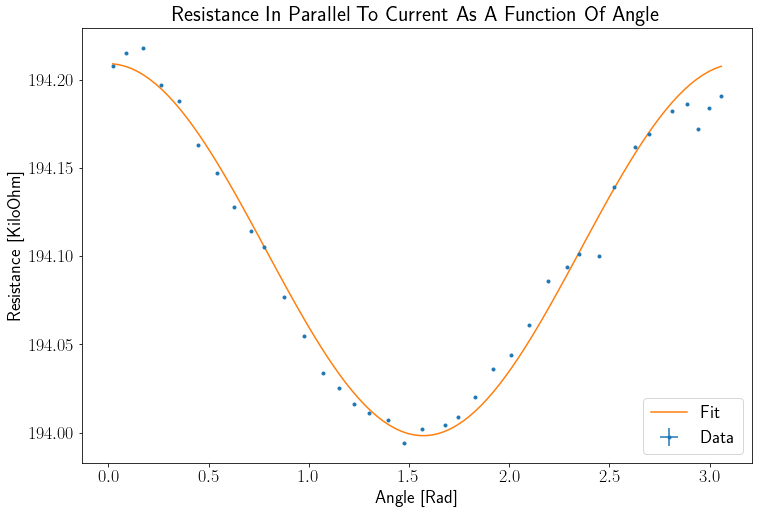

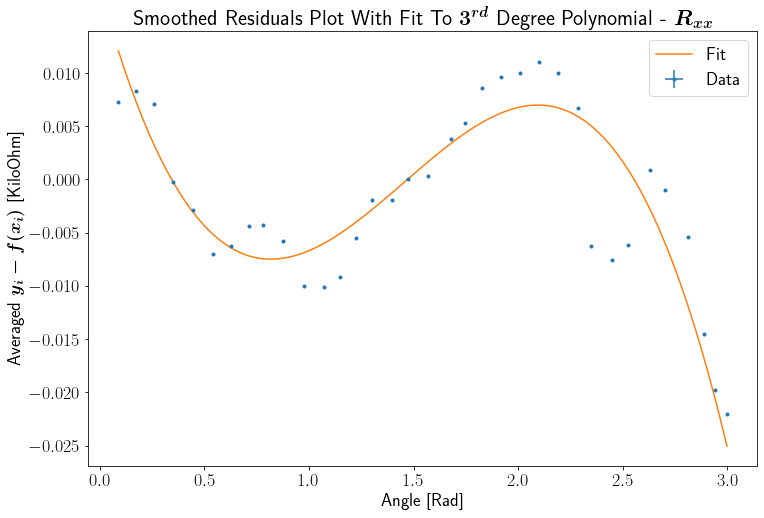

Results:

Initial parameters' values:
	0.05010000000000003 2.408483783783784
Fitted parameters' values:
	a[0] = 5.06683e-2 ± 7.413e-4 (1.463% error)
	a[1] = 2.4086756e-0 ± 6.034e-4 (0.02505% error)
Fitted parameters covariance:
[[6.987e-11 2.301e-13]
 [2.301e-13 4.630e-11]]
Chi squared: 2.753e+5
Degrees of freedom: 35
Chi squared reduced: 7.865e+3
P-probability: 0.000



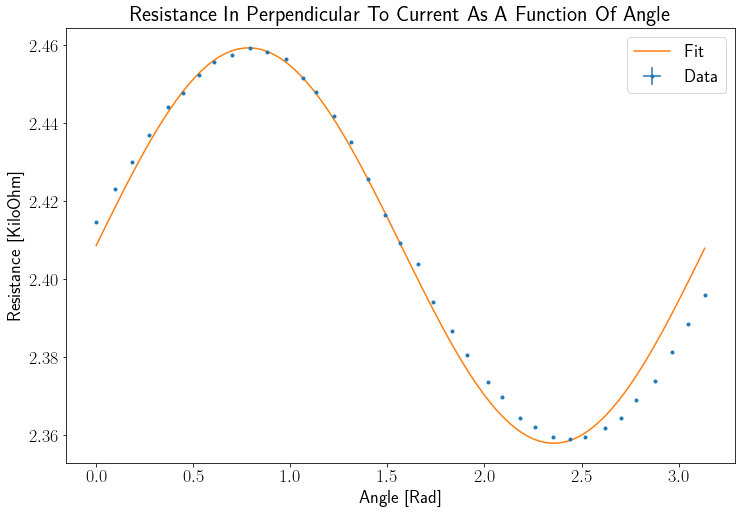

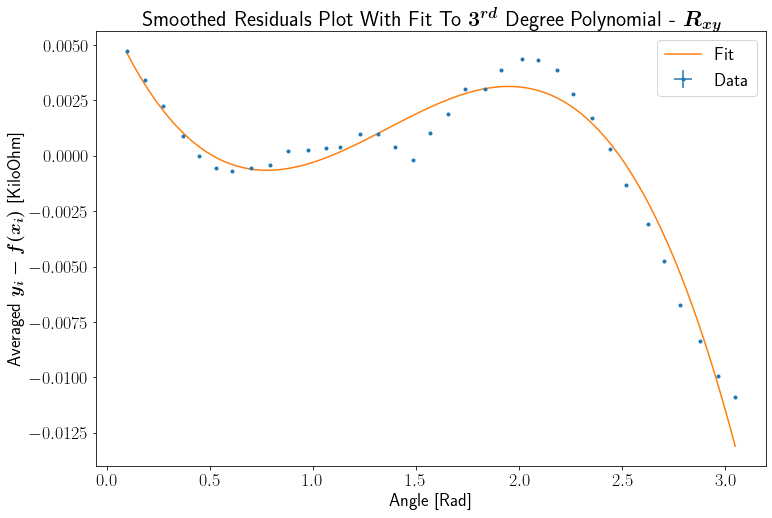

In [3]:
n = 3
Rxx = eddington.FittingData(dict(x = data[0]*np.pi/180, dx = np.zeros_like(data[0]) + 0.1*np.pi/180*1/np.sqrt(12),\
                                           y = data[1], dy = np.zeros_like(data[1]) + 0.0001/np.sqrt(12)))
xxResult = eddington.fit(Rxx,func=cosSinSq,a0=[194, 194])
xxResult.save_txt('PHE/Rxx_Results.txt')
print(xxResult)

plt.errorbar(x = Rxx.x, xerr = Rxx.xerr ,y = Rxx.y, yerr = Rxx.yerr, fmt='.', label='Data')

x =  np.linspace(Rxx.x[0],Rxx.x[-1], 100)
plt.plot(x, cosSinSq(xxResult.a,x), label='Fit')

plt.title(r'Resistance In Parallel To Current As A Function Of Angle')
plt.legend(loc='lower right')
plt.xlabel(r'Angle [Rad]')
plt.ylabel(r'Resistance [KiloOhm]')
plt.savefig('PHE/Rxx_Plot.png')
plt.show()


y = Rxx.y - np.array([cosSinSq(xxResult.a,x) for x in Rxx.x])
xxRes = eddington.FittingData(dict(x = middle(Rxx.x, n), dx = Rxx.xerr[n-1:] / np.sqrt(n),\
                                           y = moving_average(y, n), dy = Rxx.yerr[n-1:] / np.sqrt(n)))
poly3 = eddington.polynomial(3)
ResResult = eddington.fit(xxRes,func=poly3)
ResResult.save_txt('PHE/Rxx_Res.txt')
x =  np.linspace(xxRes.x[0],xxRes.x[-1], 100)

plt.errorbar(x = xxRes.x, xerr = xxRes.xerr ,y = xxRes.y, yerr = xxRes.yerr, fmt='.', label='Data')
plt.plot(x, poly3(ResResult.a,x), label='Fit')

plt.title(r'Smoothed Residuals Plot With Fit To $\boldsymbol{3^{rd}}$ Degree Polynomial - $\boldsymbol{R_{xx}}$')
plt.legend(loc='upper right')
plt.xlabel(r'Angle [Rad]')
plt.ylabel(r'Averaged $\boldsymbol{y_i-f(x_i)}$ [KiloOhm]')
plt.savefig('PHE/Rxx_Res_Plot.png')
plt.show()

Rxy = eddington.FittingData(dict(x = data[2]*np.pi/180, dx = np.zeros_like(data[2]) + 0.1*np.pi/180*1/np.sqrt(12),\
                                           y = data[3], dy = np.zeros_like(data[3]) + 0.0001/np.sqrt(12)))
xyResult = eddington.fit(Rxy,func=twoSine,a0=[(max(data[3])-min(data[3]))/2, sum(data[3])/len(data[3])])
xyResult.save_txt('PHE/Rxy_Results.txt')
print(xyResult)

plt.errorbar(x = Rxy.x, xerr = Rxy.xerr ,y = Rxy.y, yerr = Rxy.yerr, fmt='.', label='Data')

x =  np.linspace(Rxy.x[0],Rxy.x[-1], 100)
plt.plot(x, twoSine(xyResult.a,x), label='Fit')

plt.title(r'Resistance In Perpendicular To Current As A Function Of Angle')
plt.legend(loc='upper right')
plt.xlabel(r'Angle [Rad]')
plt.ylabel(r'Resistance [KiloOhm]')
plt.savefig('PHE/Rxy_Plot.png')
plt.show()

y = Rxy.y - np.array([twoSine(xyResult.a,x) for x in Rxy.x])
xyRes = eddington.FittingData(dict(x = middle(Rxy.x, n), dx = Rxy.xerr[n-1:] / np.sqrt(n),\
                                           y = moving_average(y, n), dy = Rxy.yerr[n-1:] / np.sqrt(n)))
ResResult = eddington.fit(xyRes,func=poly3)
ResResult.save_txt('PHE/Rxy_Res.txt')
x =  np.linspace(xyRes.x[0],xyRes.x[-1], 100)

plt.errorbar(x = xyRes.x, xerr = xyRes.xerr ,y = xyRes.y, yerr = xyRes.yerr, fmt='.', label='Data')
plt.plot(x, poly3(ResResult.a,x), label='Fit')

plt.title(r'Smoothed Residuals Plot With Fit To $\boldsymbol{3^{rd}}$ Degree Polynomial - $\boldsymbol{R_{xy}}$')
plt.legend(loc='upper right')
plt.xlabel(r'Angle [Rad]')
plt.ylabel(r'Averaged $\boldsymbol{y_i-f(x_i)}$ [KiloOhm]')
plt.savefig('PHE/Rxy_Res_Plot.png')
plt.show()

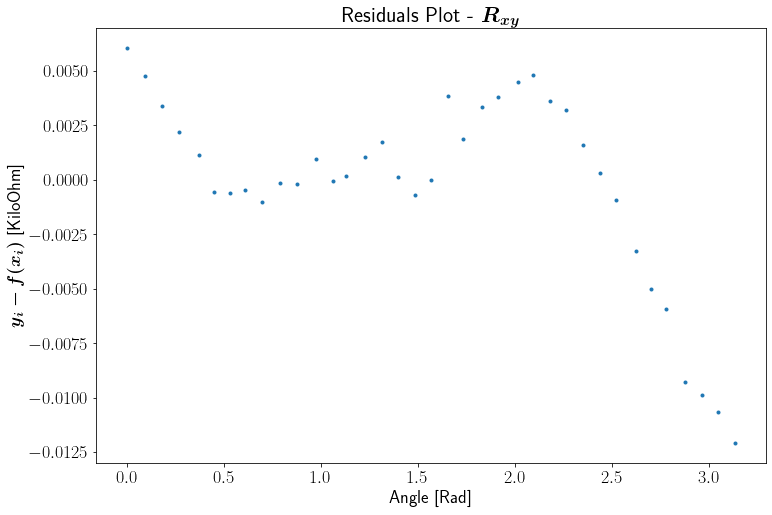

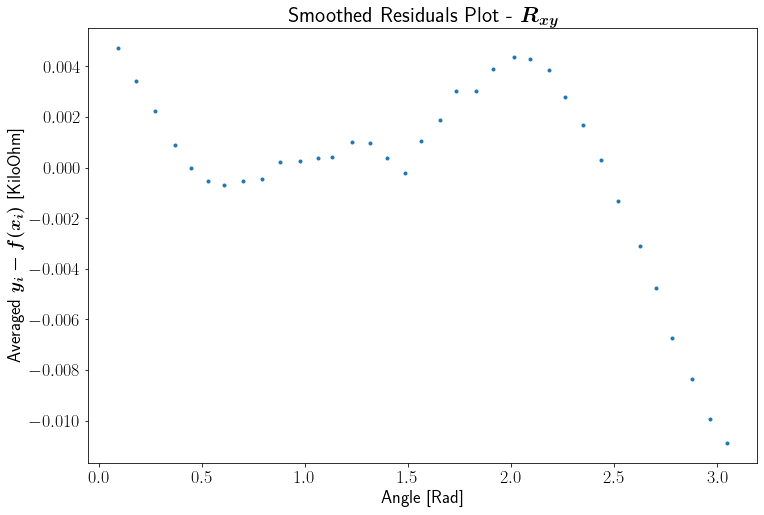

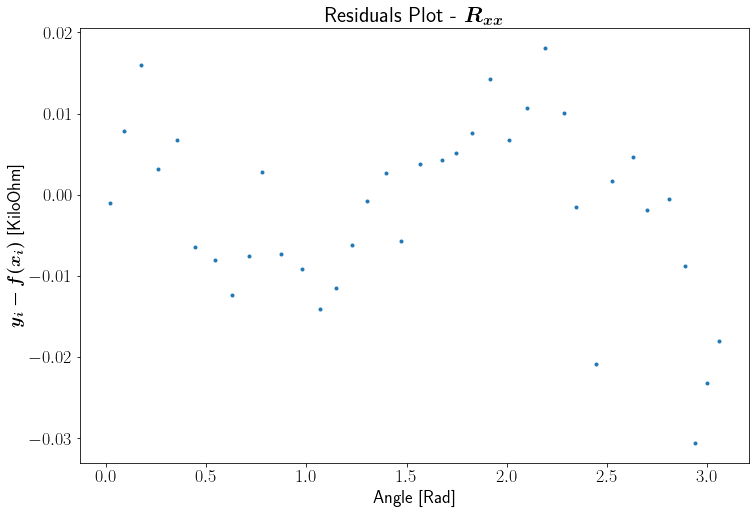

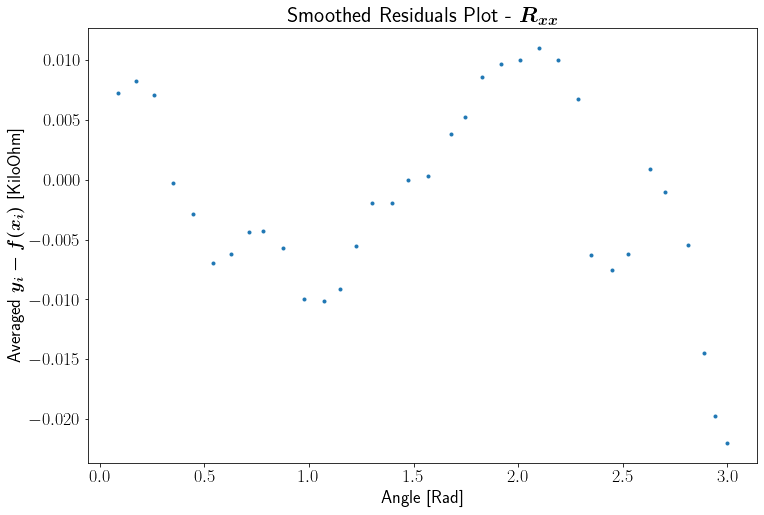

In [6]:
y = Rxy.y - np.array([twoSine(xyResult.a,x) for x in Rxy.x])
plt.errorbar(x = Rxy.x, xerr = Rxy.xerr ,y = y, yerr = Rxy.yerr, fmt='.', label='Data')
plt.title(r'Residuals Plot - $\boldsymbol{R_{xy}}$')
# plt.legend(loc='upper right')
plt.xlabel(r'Angle [Rad]')
plt.ylabel(r'$\boldsymbol{y_i-f(x_i)}$ [KiloOhm]')
plt.savefig('PHE/Rxy_Res.png')
plt.show()

plt.errorbar(x = xyRes.x, xerr = xyRes.xerr ,y = xyRes.y, yerr = xyRes.yerr, fmt='.', label='Data')
plt.title(r'Smoothed Residuals Plot - $\boldsymbol{R_{xy}}$')
# plt.legend(loc='upper right')
plt.xlabel(r'Angle [Rad]')
plt.ylabel(r'Averaged $\boldsymbol{y_i-f(x_i)}$ [KiloOhm]')
plt.savefig('PHE/Rxy_Res_Avg.png')
plt.show()

y = Rxx.y - np.array([cosSinSq(xxResult.a,x) for x in Rxy.x])
plt.errorbar(x = Rxx.x, xerr = Rxx.xerr ,y = y, yerr = Rxx.yerr, fmt='.', label='Data')
plt.title(r'Residuals Plot - $\boldsymbol{R_{xx}}$')
# plt.legend(loc='upper right')
plt.xlabel(r'Angle [Rad]')
plt.ylabel(r'$\boldsymbol{y_i-f(x_i)}$ [KiloOhm]')
plt.savefig('PHE/Rxx_Res.png')
plt.show()

plt.errorbar(x = xxRes.x, xerr = xxRes.xerr ,y = xxRes.y, yerr = xxRes.yerr, fmt='.', label='Data')
plt.title(r'Smoothed Residuals Plot - $\boldsymbol{R_{xx}}$')
# plt.legend(loc='upper right')
plt.xlabel(r'Angle [Rad]')
plt.ylabel(r'Averaged $\boldsymbol{y_i-f(x_i)}$ [KiloOhm]')
plt.savefig('PHE/Rxx_Res_Avg.png')
plt.show()


Results:

Initial parameters' values:
	194 194
Fitted parameters' values:
	a[0] = 1.94209617e+2 ± 4.465e-3 (2.299e-3% error)
	a[1] = 1.93993059e+2 ± 4.919e-3 (2.536e-3% error)
Fitted parameters covariance:
[[ 2.471e-09 -1.678e-09]
 [-1.678e-09  2.998e-09]]
Chi squared: 1.372e+5
Degrees of freedom: 17
Chi squared reduced: 8.070e+3
P-probability: 0.000



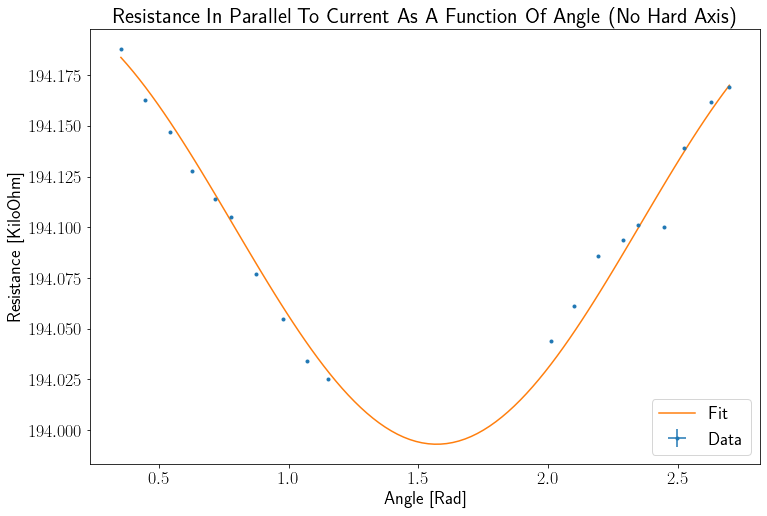

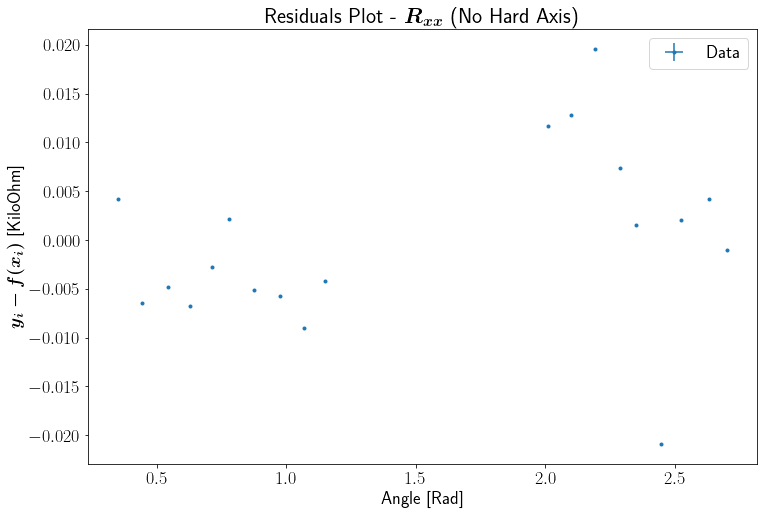

In [37]:
n=1
wind = 20
mask = ((wind < data[0]) & (data[0] < 90-wind)) | ((90+wind < data[0]) & (data[0] < 180-wind))
Rxx = eddington.FittingData(dict(x = data[0][mask]*np.pi/180, dx = np.zeros_like(data[0][mask]) + 0.1*np.pi/180*1/np.sqrt(12),\
                                           y = data[1][mask], dy = np.zeros_like(data[1][mask]) + 0.0001/np.sqrt(12)))
xxResult = eddington.fit(Rxx,func=cosSinSq,a0=[194, 194])
xxResult.save_txt('PHE/RxxNoHard_Results.txt')
print(xxResult)

plt.errorbar(x = Rxx.x, xerr = Rxx.xerr ,y = Rxx.y, yerr = Rxx.yerr, fmt='.', label='Data')

x =  np.linspace(Rxx.x[0],Rxx.x[-1], 100)
plt.plot(x, cosSinSq(xxResult.a,x), label='Fit')

plt.title(r'Resistance In Parallel To Current As A Function Of Angle (No Hard Axis)')
plt.legend(loc='lower right')
plt.xlabel(r'Angle [Rad]')
plt.ylabel(r'Resistance [KiloOhm]')
plt.savefig('PHE/RxxNoHard_Plot.png')
plt.show()

y = Rxx.y - np.array([cosSinSq(xxResult.a,x) for x in Rxx.x])
xxRes = eddington.FittingData(dict(x = middle(Rxx.x, n), dx = Rxx.xerr[n-1:] / np.sqrt(n),\
                                           y = moving_average(y, n), dy = Rxx.yerr[n-1:] / np.sqrt(n)))
poly3 = eddington.polynomial(3)
ResResult = eddington.fit(xxRes,func=poly3)
# ResResult.save_txt('PHE/RxxNoHard_Res.txt')
x =  np.linspace(xxRes.x[0],xxRes.x[-1], 100)

plt.errorbar(x = xxRes.x, xerr = xxRes.xerr ,y = xxRes.y, yerr = xxRes.yerr, fmt='.', label='Data')
# plt.plot(x, poly3(ResResult.a,x), label='Fit')

plt.title(r'Residuals Plot - $\boldsymbol{R_{xx}}$ (No Hard Axis)')
plt.legend(loc='upper right')
plt.xlabel(r'Angle [Rad]')
plt.ylabel(r'$\boldsymbol{y_i-f(x_i)}$ [KiloOhm]')
plt.savefig('PHE/RxxNoHard_Res_Plot.png')
plt.show()

In [40]:
Names = ['Amit','Koral','Adir','Revital','Elena','Naah','Ronen']
for i in range(len(Names)):
    l = len(Names)
    print(f'{Names[i]} Dogem Positive: {Names[-l+i+1]}, Negative: {Names[-l+i+2]}, Matkin: {Names[-l+i+3]}')

Amit Dogem Positive: Koral, Negative: Adir, Matkin: Revital
Koral Dogem Positive: Adir, Negative: Revital, Matkin: Elena
Adir Dogem Positive: Revital, Negative: Elena, Matkin: Naah
Revital Dogem Positive: Elena, Negative: Naah, Matkin: Ronen
Elena Dogem Positive: Naah, Negative: Ronen, Matkin: Amit
Naah Dogem Positive: Ronen, Negative: Amit, Matkin: Koral
Ronen Dogem Positive: Amit, Negative: Koral, Matkin: Adir
